In [38]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the CSV file
df = pd.read_csv('Filtered_Video_Games_Data_Top_Genres.csv', header=None)  # Set header=None if there's no header

# Get the x and y values from the CSV file
image_paths = df[0].values[1:]
labels = df[3].values[1:]

# Encode the labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Suppose you started with a list of genre names like this:
genres = ['Action', 'Adventure', 'Role-Playing', 'Sports', 'Shooter', 'Platform', 'Strategy', 'Puzzle', 'Racing', 'Simulation']

# Encode genres into integers
le = LabelEncoder()
Y = le.fit_transform(genres)

# Or build a mapping dictionary:
genre_map = {code: label for label, code in zip(encoder.classes_, encoder.transform(encoder.classes_))}
print(genre_map)

{np.int64(0): 'Action', np.int64(1): 'Adventure', np.int64(2): 'Platform', np.int64(3): 'Puzzle', np.int64(4): 'Racing', np.int64(5): 'Role-Playing', np.int64(6): 'Shooter', np.int64(7): 'Simulation', np.int64(8): 'Sports', np.int64(9): 'Strategy'}


In [39]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np

# Image processing
IMAGE_SIZE = (200, 200)
base_url = 'https://www.vgchartz.com'

def load_image(image_path):
    full_url = base_url + image_path
    response = requests.get(full_url)
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img = img.resize(IMAGE_SIZE)
        return np.array(img)  # Keep 3D shape (200, 200, 3)
    else:
        raise Exception(f"Image failed to load from {full_url}")

# Load and flatten all images
X = np.array([load_image(p) for p in image_paths[:1000]])
Y = np.array(labels_encoded[:1000])

In [40]:
# Split train/test
x_train = X[0:500]
y_train = Y[0:500]
x_test = X[500:]
y_test = Y[500:]

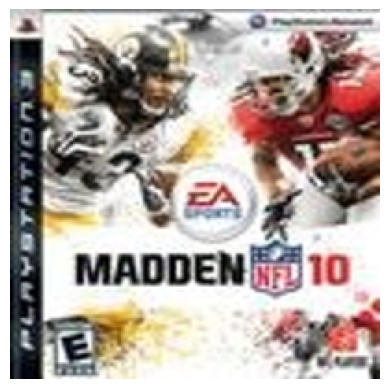

This is Sports


In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Pick a random index
random_image = np.random.randint(len(Y))

# Display the image, normalize pixel values to [0,1] for matplotlib
plt.imshow(X[random_image] / 255.0)
plt.axis('off')
plt.show()

# Print label
print("This is %s" % genre_map[Y[random_image]])

Test Accuracy: 34.40%


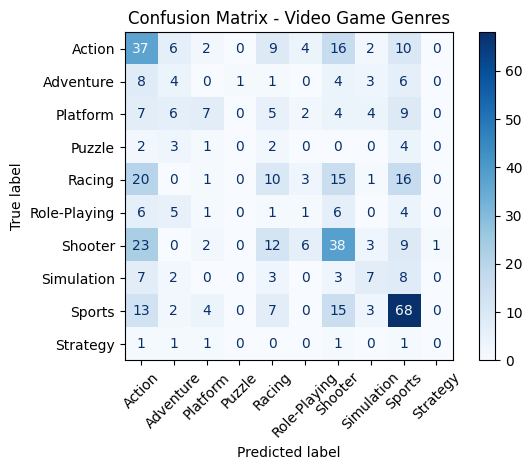

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Flattens the images into the data-matrix format that most sklearn models accept
x_raw_train = x_train.flatten().reshape([x_train.shape[0], 200*200*3])
x_raw_test = x_test.flatten().reshape([x_test.shape[0], 200*200*3])

# Normalize input
x_raw_train = x_raw_train / 255.0
x_raw_test = x_raw_test / 255.0

# Train
clf = LogisticRegression(max_iter=1000)
clf.fit(x_raw_train, y_train)

# Predict
y_pred = clf.predict(x_raw_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Ensure all genre labels are included
cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(encoder.classes_)))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Video Game Genres")
plt.tight_layout()
plt.show()

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import preprocess_input

x_train_pre = preprocess_input(x_train)
x_test_pre = preprocess_input(x_test)

base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(200, 200, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train_pre, y_train,
          epochs=5,
          batch_size=32,
          validation_data=(x_test_pre, y_test))

loss, accuracy = model.evaluate(x_test_pre, y_test)
print(f"\nTest Accuracy (retrained output layer): {accuracy:.2%}")

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - accuracy: 0.2455 - loss: 2.2447 - val_accuracy: 0.2980 - val_loss: 2.1141
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 153s 9s/step - accuracy: 0.4098 - loss: 1.6364 - val_accuracy: 0.3680 - val_loss: 1.8473
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 201s 9s/step - accuracy: 0.5484 - loss: 1.3330 - val_accuracy: 0.4140 - val_loss: 1.7030
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 202s 9s/step - accuracy: 0.6107 - loss: 1.0947 - val_accuracy: 0.4520 - val_loss: 1.6188
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 200s 9s/step - accuracy: 0.6847 - loss: 0.9545 - val_accuracy: 0.4660 - val_loss: 1.5726
16/16 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.4798 - loss: 1.5242

Test Accuracy (retrained output layer): 46.60%


In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import preprocess_input

x_train_pre = preprocess_input(x_train)
x_test_pre = preprocess_input(x_test)

base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(200, 200, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train_pre, y_train,
          epochs=10,
          batch_size=32,
          validation_data=(x_test_pre, y_test))

loss, accuracy = model.evaluate(x_test_pre, y_test)
print(f"\nTest Accuracy (retrained output layer): {accuracy:.2%}")

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 173s 10s/step - accuracy: 0.3061 - loss: 2.0968 - val_accuracy: 0.3240 - val_loss: 2.0646
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 191s 9s/step - accuracy: 0.5186 - loss: 1.4699 - val_accuracy: 0.4200 - val_loss: 1.7922
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 201s 9s/step - accuracy: 0.5884 - loss: 1.1927 - val_accuracy: 0.4300 - val_loss: 1.6942
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 201s 9s/step - accuracy: 0.6371 - loss: 1.0915 - val_accuracy: 0.4480 - val_loss: 1.6178
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 204s 9s/step - accuracy: 0.7012 - loss: 0.9441 - val_accuracy: 0.4560 - val_loss: 1.6082
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 148s 10s/step - accuracy: 0.7106 - loss: 0.8802 - val_accuracy: 0.4720 - val_loss: 1.5873
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 181s 8s/step - accuracy: 0.7686 - loss: 0.7770 - val_accuracy: 0.4820 - val_loss: 1.5254
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 140s 8s/step - accuracy: 0.8175 - loss: 0.6766 - val_accuracy: 0.4900 -

In [50]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import preprocess_input

x_train_pre = preprocess_input(x_train)
x_test_pre = preprocess_input(x_test)

base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(200, 200, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', # top1 accuracy
                       tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_accuracy') # top3 accuracy
                       ])

model.fit(x_train_pre, y_train,
          epochs=15,
          batch_size=32,
          validation_data=(x_test_pre, y_test))

loss, accuracy, top3_accuracy = model.evaluate(x_test_pre, y_test)
print(f"\nTest Accuracy (retrained output layer): {accuracy:.2%}")
print(f"Test Accuracy (Top-3): {top3_accuracy:.2%}")

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 173s 10s/step - accuracy: 0.1665 - loss: 2.5976 - top3_accuracy: 0.4654 - val_accuracy: 0.2860 - val_loss: 2.2309 - val_top3_accuracy: 0.5960
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 126s 8s/step - accuracy: 0.3854 - loss: 1.8744 - top3_accuracy: 0.7147 - val_accuracy: 0.3880 - val_loss: 1.9051 - val_top3_accuracy: 0.6620
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 147s 8s/step - accuracy: 0.5126 - loss: 1.4441 - top3_accuracy: 0.7837 - val_accuracy: 0.4180 - val_loss: 1.7379 - val_top3_accuracy: 0.7100
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 158s 9s/step - accuracy: 0.5867 - loss: 1.1691 - top3_accuracy: 0.8739 - val_accuracy: 0.4480 - val_loss: 1.6571 - val_top3_accuracy: 0.7420
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 200s 9s/step - accuracy: 0.6109 - loss: 1.0607 - top3_accuracy: 0.8945 - val_accuracy: 0.4500 - val_loss: 1.6602 - val_top3_accuracy: 0.7320
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 203s 9s/step - accuracy: 0.6765 - loss: 0.9539 - top3_accuracy: 0.

16/16 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step


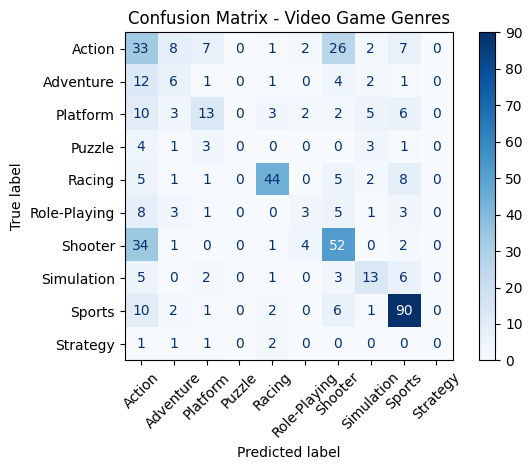

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

y_pred_probs = model.predict(x_test_pre)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(encoder.classes_)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Video Game Genres")
plt.tight_layout()
plt.show()